## Deep Learning
   #### Computer Vision Winter Semester 2020/2021 by Clemens Spielvogel
    
Deep Learning algorithms have recently become very popular. Reasons for this are increased availability of data, computational power and advances in algorithm architectures. Deep learning is usually performed via neural network algorithms. Neural networks consist of connected layers of neurons and can be shall (few layers) or deep (many layers). Goal of this notebook is to provide practical examples of how neural networks can be applied for image data.
   
Installations (Ubuntu)
   * If you do have a GPU: \$ conda install tensorflow-gpu (recommended)
   * If you do not have a GPU: \$ pip install tensorflow
   * \$ pip install keras
   
Resources:
   * Tensorflow tutorials: https://www.tensorflow.org/tutorials/
   * Tensorflow guide: https://www.tensorflow.org/guide/
   * Tensorflow documentation: https://www.tensorflow.org/versions/r1.14/api_docs/python/tf
   * Keras documentation: https://keras.io/

#### Building a Neural Network using Keras and Tensorflow
Keras provides an easy-to-use interface for tensorflow but also comes with its own backend functionalities. There are many frameworks for deep learning, however Keras is one of the most used ones. Here, we will use Keras for building a classical neural network.

In [1]:
import tensorflow as tf
import keras

from sklearn.preprocessing import LabelEncoder, StandardScaler

import os
import cv2
import scipy
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

print("Tensorflow version", tf.__version__)
print("Keras version", keras.__version__)

Using TensorFlow backend.


Tensorflow version 2.1.0
Keras version 2.3.1


In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value) # tf.set_random_seed(seed_value) on older TF versions

In [3]:
def display_array(array):
    """Plotting numpy array in jupyter notebbok"""
    if len(array.shape) > 2:
        array = cv2.cvtColor(array.astype("uint8"), cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    pil_img = Image.fromarray(array)
    display(pil_img)

The data we will be using are images of three kinds of fruits, apples, bananas and oranges. In total, the data set contains 232 images of apples, 218 of bananas and 206 of oranges. The dimensions are different for each image. To unify the image size and to decrease the run time, the images will be downsampled.

In [4]:
# Load image data and labels into separate containers
data_dir = "Data/fruits"

filenames = []
string_labels = []
images = []
label_folders = os.listdir(data_dir)
for folder in label_folders:
    folder_path = os.path.join(data_dir, folder)
    filenames = os.listdir(folder_path)
    filepaths = [os.path.join(folder_path, name) for name in filenames]
    images += [cv2.imread(file, 0) for file in filepaths]
    string_labels += [folder for _ in filenames]

images = np.array(images)
string_labels = np.array(string_labels)

print(len(images))
print(len(string_labels))
print(np.unique(string_labels))

656
656
['apple' 'banana' 'orange']


apple: 232
banana: 218
orange: 206


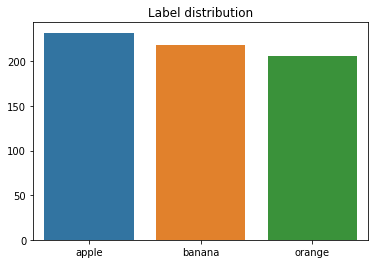

In [5]:
# Convert string labels to integers
encoder = LabelEncoder()
labels = encoder.fit_transform(string_labels)

# Get label frequency
labels = np.array(labels)
labels_unique, label_counts = np.unique(labels, return_counts=True)

# Display label frequency as text
string_labels_unique = encoder.inverse_transform(labels_unique)
[print("{}: {}".format(label, count)) for (label, count) in zip(string_labels_unique, label_counts)]

# Plot label frequency
sns.barplot(x=string_labels_unique, 
            y=label_counts, 
            ci=0)
plt.title("Label distribution")
plt.show()

In [6]:
# Shrink images and flatten to 1D vector
images_resized = [cv2.resize(img, (100, 100)) for img in images]
features = np.array([img.flatten() for img in images_resized])

Original image examples:


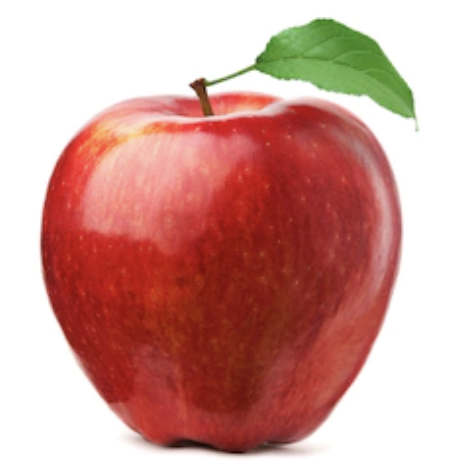

(476, 458, 3)


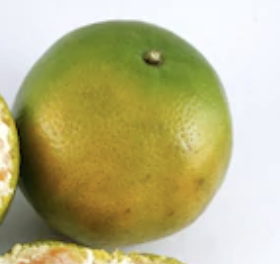

(264, 280, 3)

Neural network input image examples:


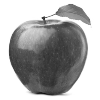

(100, 100)


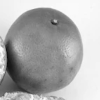

(100, 100)


In [7]:
# Display original and resampled images
apple_file = os.listdir("Data/fruits/apple")[0]
orange_file = os.listdir("Data/fruits/orange")[-1]

apple = cv2.imread(os.path.join("Data/fruits/apple", apple_file))
orange = cv2.imread(os.path.join("Data/fruits/orange", orange_file))

print("Original image examples:")
display_array(apple)
print(apple.shape)
display_array(orange)
print(orange.shape)
print()

print("Neural network input image examples:")
display_array(images_resized[0])
print(images_resized[0].shape)
display_array(images_resized[-1])
print(images_resized[-1].shape)

In [8]:
np.random.seed(seed_value)

# Shuffle features and labels in same order
random_index_order = np.random.permutation(len(labels))
features = features[random_index_order]
labels = labels[random_index_order]

# Determine split sizes
train_ratio = 0.7
test_ratio = 0.3
train_size = math.floor(train_ratio * len(labels))
test_size = math.floor(test_ratio * len(labels))

# Create splitted sets
X_train, y_train = np.array(features[:train_size]), np.array(labels[:train_size])
X_test, y_test = np.array(features[train_size:]), np.array(labels[train_size:])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Create keras model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=10000, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation="softmax"))

In [10]:
# Create model
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

In [11]:
# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

In [12]:
# Train model
history = model.fit(X_train, 
                    y_train,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[callback],
                    verbose=True)

Train on 367 samples, validate on 92 samples
Epoch 1/100
367/367 [==============================] - 0s 994us/step - loss: 1.0253 - sparse_categorical_accuracy: 0.5477 - val_loss: 0.5790 - val_sparse_categorical_accuracy: 0.7065
Epoch 2/100
367/367 [==============================] - 0s 194us/step - loss: 0.7523 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.5017 - val_sparse_categorical_accuracy: 0.8587
Epoch 3/100
367/367 [==============================] - 0s 179us/step - loss: 0.4800 - sparse_categorical_accuracy: 0.8202 - val_loss: 0.5245 - val_sparse_categorical_accuracy: 0.8261
Epoch 4/100
367/367 [==============================] - 0s 188us/step - loss: 0.3052 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8696
Epoch 5/100
367/367 [==============================] - 0s 196us/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.8261
Epoch 6/100
367/367 [===================

In [13]:
print(history.history)

{'val_loss': [0.5789542198181152, 0.5016773096893145, 0.5245374739170074, 0.4820600864679917, 0.7334408215854479, 0.6503176792808201, 0.5450621441654537, 0.7972859507021697, 0.634237650943839, 0.6613465366156205, 0.6434096668077551, 0.7794447295043779, 0.98175935641579, 1.2490918169850889, 0.8934840248978656, 0.8829699599224589, 1.2006067478138467], 'val_sparse_categorical_accuracy': [0.70652174949646, 0.8586956262588501, 0.8260869383811951, 0.8695651888847351, 0.8260869383811951, 0.804347813129425, 0.8695651888847351, 0.8369565010070801, 0.8152173757553101, 0.8260869383811951, 0.79347825050354, 0.8369565010070801, 0.8369565010070801, 0.8369565010070801, 0.8586956262588501, 0.8369565010070801, 0.8260869383811951], 'loss': [1.0252985718789478, 0.7523305939068912, 0.47997856391872956, 0.3051519779239753, 0.22397527366632985, 0.1820010896924406, 0.18733324601799656, 0.18011809020666075, 0.1647188424739266, 0.08549041403533653, 0.08192246376818467, 0.051045578092397556, 0.02320555558083046

In [14]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Display output
print("ACC:", round(test_acc, 2))

197/197 [==============================] - 0s 132us/step
ACC: 0.78


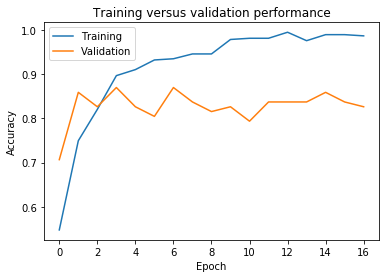

In [15]:
# Plot Performance
num_epochs = len(history.history["sparse_categorical_accuracy"])
sns.lineplot(np.arange(num_epochs), history.history["sparse_categorical_accuracy"])
sns.lineplot(np.arange(num_epochs), history.history["val_sparse_categorical_accuracy"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training versus validation performance")
plt.show()

### Same network with augmented images

In [16]:
def augment_data(X_train, y_train, size=0):
    """ONLY FOR TRAINING DATA. Generate synthetic images by simple transformations. 
    Size is the number of samples to be returned.  If size is set to zero, the same number 
    as input images is returned."""
    
    # Convert images to 2D
    images = [image.reshape(100, 100) for image in X_train]
    
    # Set number of images to augment to the same number as input images if size is zero
    if size == 0:
        size = len(images)
    
    # Create augmented images equal to size
    augmented_images = []
    new_labels = []
    for i in np.arange(size):
        
        # Select random images
        random_index = np.random.choice(np.arange(0, len(images)))
        img = images[random_index]
        
        # Rotate image with random parameters
        rows,cols = img.shape[:2]
        rot_matrix = cv2.getRotationMatrix2D(center=(cols/2, rows/2), 
                                             angle=np.random.randint(0, 45), 
                                             scale=1)
        img = cv2.warpAffine(img, rot_matrix, (cols,rows))
        
        # Add augmented image and corresponding labels to result containers
        augmented_images.append(img.flatten())
        new_labels.append(labels[random_index])
        
    return np.array(augmented_images), np.array(new_labels)

In [17]:
# Create augmented training data set
X_train_augmented, y_train_augmented = augment_data(X_train, y_train, 5000)

In [18]:
def transform_to_img_range(array1d):
    """Convert all values in a 1D array to be between 0 and 255"""
    new_array = []
    for old_val in array1d:
        old_range = np.max(array1d) - np.min(array1d)
        if old_range == 0:
            new_val = 0
        else:
            new_val = ((old_val - np.min(array1d)) * 255 / old_range)
            
        new_array.append(new_val)
    
    return np.round(np.array(new_array)).astype(np.int16)

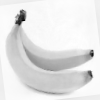

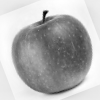

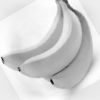

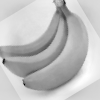

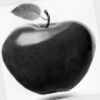

In [19]:
# Display example augmented images
for i in range(0, 5):
    # Revert standardization and 
    nonstd_img = transform_to_img_range(scaler.inverse_transform(X_train_augmented[i]))
    reshaped_img = nonstd_img.reshape(100, 100)
    recast_img = reshaped_img.astype(np.uint8)

    display_array(recast_img)

In [20]:
# Create keras model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=10000, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation="softmax"))

# Create model
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Train model
history_augmented = model.fit(X_train_augmented, 
                              y_train_augmented,
                              validation_split=0.2,
                              epochs=100,
                              callbacks=[callback],
                              verbose=True)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 207us/step - loss: 0.4708 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.8820
Epoch 2/100
4000/4000 [==============================] - 1s 177us/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9355 - val_loss: 0.1296 - val_sparse_categorical_accuracy: 0.9540
Epoch 3/100
4000/4000 [==============================] - 1s 176us/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.0566 - val_sparse_categorical_accuracy: 0.9760
Epoch 4/100
4000/4000 [==============================] - 1s 176us/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.0944 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/100
4000/4000 [==============================] - 1s 177us/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.1665 - val_sparse_categorical_accuracy: 0.9500
Epoch 6/100
4000/4000 [====

197/197 [==============================] - 0s 132us/step
ACC: 0.8


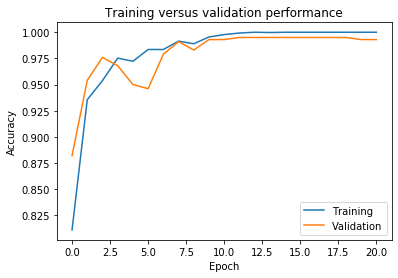

In [21]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Display output
print("ACC:", round(test_acc, 2))

# Plot performance
num_epochs = len(history_augmented.history["sparse_categorical_accuracy"])
sns.lineplot(np.arange(num_epochs), history_augmented.history["sparse_categorical_accuracy"])
sns.lineplot(np.arange(num_epochs), history_augmented.history["val_sparse_categorical_accuracy"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training versus validation performance")
plt.show()

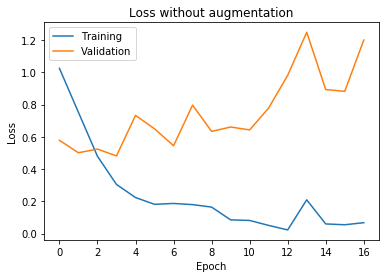

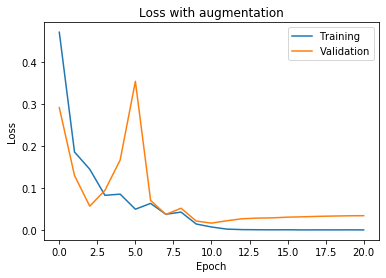

In [22]:
# Plot loss for model with and without augmentation
num_epochs = len(history.history["loss"])
sns.lineplot(np.arange(num_epochs), history.history["loss"])
sns.lineplot(np.arange(num_epochs), history.history["val_loss"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss without augmentation")
plt.show()

num_epochs = len(history_augmented.history["loss"])
sns.lineplot(np.arange(num_epochs), history_augmented.history["loss"])
sns.lineplot(np.arange(num_epochs), history_augmented.history["val_loss"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss with augmentation")
plt.show()